# Popular Data science questions

While [Data science](https://en.wikipedia.org/wiki/Data_science) may be a relatively new field, it's there to stay, and it is increasingly popular. Which also means that many people want to learn about Data science. Now suppose you want to help people to learn - and create content for that - a question that you have to answer is what is it that people want to learn about in data science.

This study aims to find answers to that question. By analyzing data for the (proxy) question: "What questions do people ask about Data science?".

This notebook contains the following sections:
1. Introduction
2. Extracting the data
3. Exploring and cleaning the data
4. Popular tags, further analysis
5. Deep learning, popularity over time
6. Conclusion


## 1. Introduction
This introduction section describes our data source and how we will make use it.

### Stack Exchange

To find answers to our question, not surprisingly, we'll turn to the internet. A great source for figuring out what people want to learn about seems to be [Stack Exchange](https://stackexchange.com/). Stack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and.... data science! On these sites, anyone (with an account) can ask questions! There are millions of questions being asked - and answered - so analyzing these questions should get us insights that we are looking for.

Another important reason to select the Stack Exchange sites for our investigation, is that it is easy to extract data from it. (Which we'll see below.)

Currently, there are 178 sites under Stack Exchange; follow [this link](https://stackexchange.com/sites?view=list#questions) to get an overview, sorted on the number of questions posted.




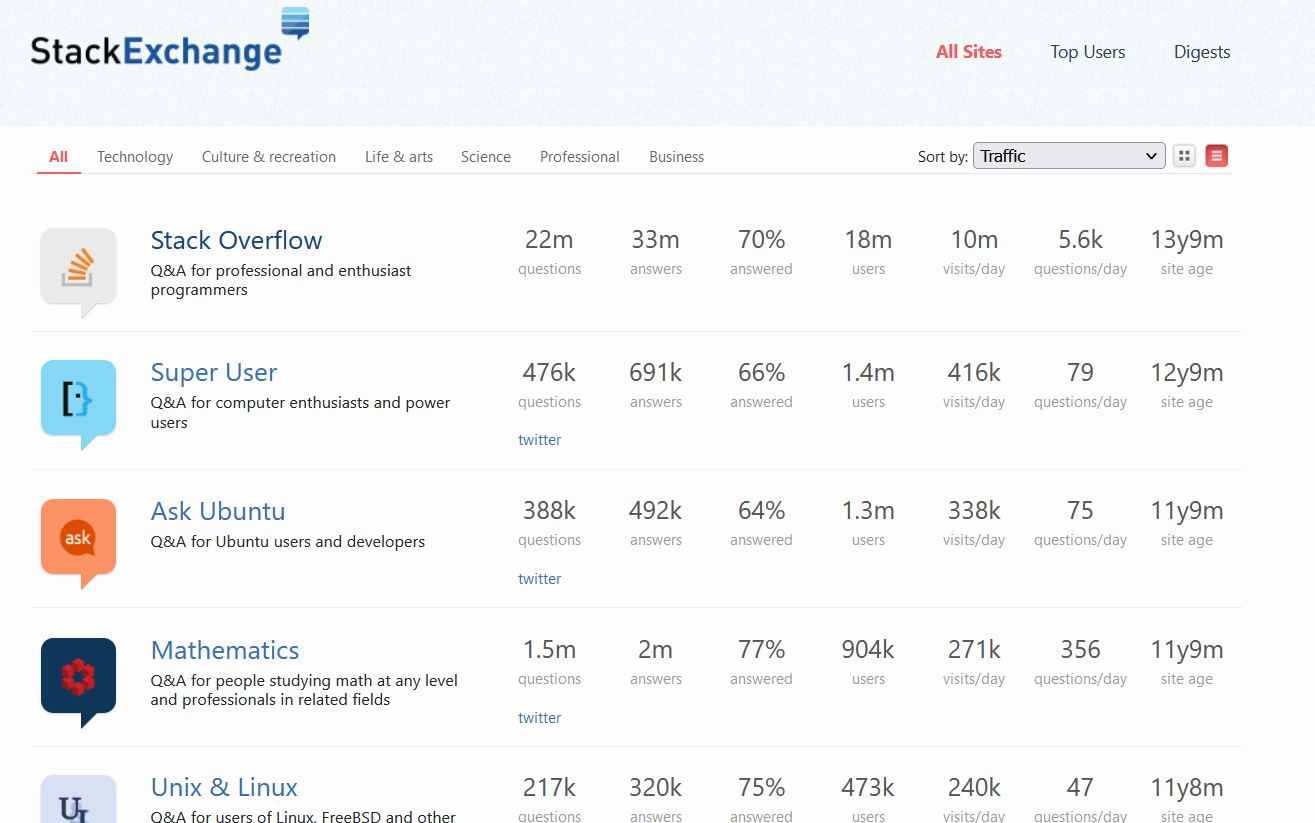

### Stack Exchange - Data science 

One of the Stack Exchange sites is [Data science](https://datascience.stackexchange.com/).

Data science is a multi-disciplanary field though, which means there are multiple other Stack Exchange sites that are of interest as well, e.g. sites such as [Artificial Intelligence](https://ai.stackexchange.com/) and well-known coding Q&A [Stack Overflow](https://stackoverflow.com/) (without which this study would not have materialized!).

For this study, we will limit ourselves to the [Data science](https://datascience.stackexchange.com/) forum though. Containing over 33,000 questions already, all about Data science, seems a good place to start at least.


### Useful data

Before we start extracting any data, let's first explore Stack Exchange a bit more, which will increase our understanding of data that may be of interest. When taking a look at [the Data science site](https://datascience.stackexchange.com/) (and note that the set-up is the same for all other sites), and also by going through [the Stack Exchange tour](https://stackexchange.com/tour) we can learn that:
* focus is on concrete questions that require an actual answer (and not on discussion topics, or chit-chat)
* anybody can ask, anybody can answer
* good answers are voted up, and rise to the top
* questions themselves can also get voted for
* all questions are tagged with their subject areas
* for every question, we can see at a glance the number of votes, the number of views and the number of answers

For our goal of figuring out "what is that people want to learn (ask questions about)", the *tags* (such as "machine-learning" or "python") seem very interesting. E.g. if we analyze:
* tags that are *used* a lot in the first place
* tags that are used in questions that are *viewed* a lot
* tags that are used in questions that are *voted for* a lot

we should be getting insights.


### Some technical preparations

At this point, let's insert some commands for the visualization of this notebook.

Make (further) images appear left-aligned:

In [1]:
%%html
<style>
    img[alt=aligned_image] { float : left; }
</style>

Limit the size of the output window, also when watching this in Notebook viewer:

In [2]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 400px; 
}
</style>

Also, let's import the Python libraries that we will be using.

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## 2. Extracting the data

Stack Exchange provides a public data base for each of its websites - which is very helpful to retrieve the data. Via [this link](https://data.stackexchange.com/datascience/query/new) we can query and explore Data Science Stack Exchange's database using SQL. Query results can be saved in .csv-format, which enables us to import the data into Python objects in the next stage.

Having explored the database schema, the following tables are interesting, that is, contain the information for which we identified that we want to use it.
* **Posts.** One entry for every post, including relevant information like creation date, number of views. And a field with all tags.
* **PostsTypes.** Reference table: every post is of a particular type. We may need to use this to filter.
* **Tags.** Overview of all tags, with some information.
* **PostsTags.** While "Posts" contains a field with all tags, there turns out to be this table as well that appears to contain one entry for every post-tag combination. (So if a posts has 4 tags, there are 4 entries in this table). That may come in handy.

What follows is a description of data exploration done, including a copy of the SQL queries that were performed. Relevant results were saved in .csv files.

Let's run this query to figure out the number of posts per type.
```
SELECT p.PostTypeId,
       pt.Name,
       COUNT(p.Id) AS NumberOfPosts
  FROM Posts p
       LEFT JOIN PostTypes pt ON p.PostTypeId = pt.Id
 GROUP BY p.PostTypeId, pt.Name
 ORDER BY p.PostTypeId
```
And show the result (as a picture):

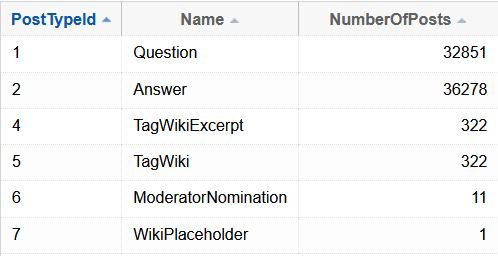

Given the volumes, only "Question" and "Answer" may be relevant. Then, "Answer" is not some sort of other category, but is, as the name already says, an answer to a Question: it contains a ParentID that refers to a Question. (I checked some examples). So we can exclude those.

So let's only extract Posts having PostTypeID = 1.

Then, while it could be interesting to see trends over time, for our goal it is most interesting to look at recent posts only: what is that people are interested in now. Given that it at the time of writing it is April 2022, let's extract posts of the previous year (2021).

Posts has a lot of columns. We'll retrieve those columns that may be of interest. (We can always drop some columns later). Most colums names are self-explanatory. Let's explain some:
* **Score**. This is times-upvoted minus times-downvoted for the post.
* **ViewCount**. Number of times that a post was views
* **Tags**. One field containing all tags for the post.
* **FavoriteCount**. Number of times this was marked by someone as a favorite.


We'll run the following query:

```
SELECT Id, 
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Title,
       Tags,
       AnswerCount,
       FavoriteCount
  FROM Posts
 WHERE PostTypeId = 1
   AND CreationDate >= Convert(datetime, '2021-01-01' )
   AND CreationDate <  Convert(datetime, '2022-01-01' )
```
And again show (a sample of) the results in a picture:

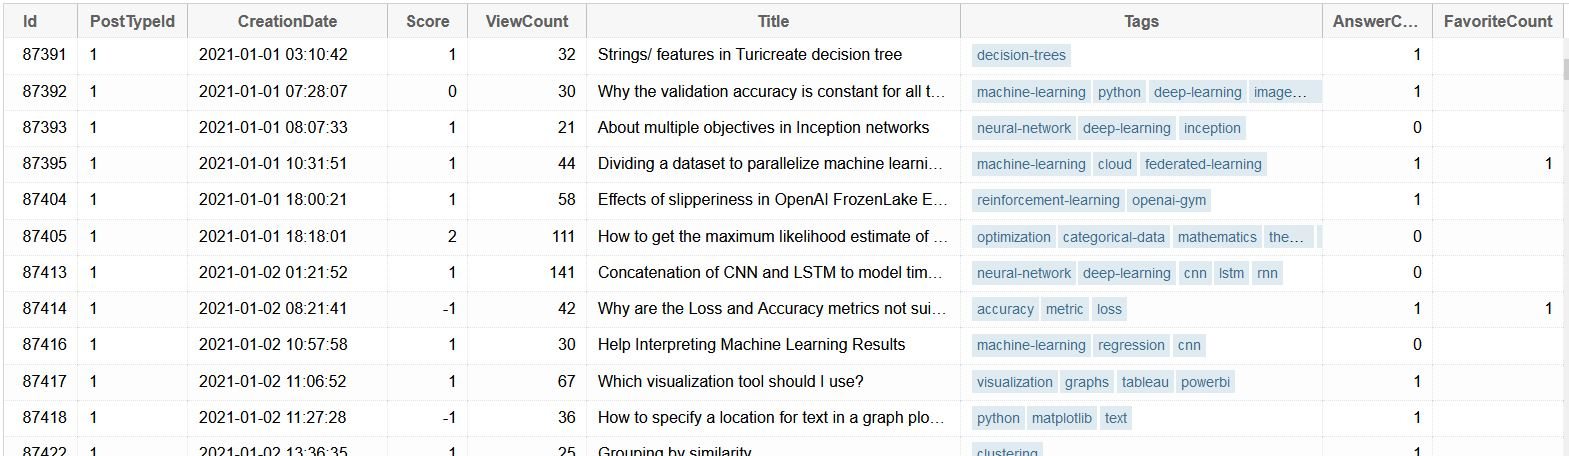

That looks good. I've downloaded this query result in .csv-format (`SelectedPosts.csv`), and we can import that later to start our analysis.

As mentioned, there appears to be another table though to get the tags for every post from: `Tags`. 
Let's do a quick check whether indeed it gives the same information, by checking it for one of the posts in the above screenshot. Let's run:
```
SELECT pt.PostID,
       pt.TagID,
       t.TagName
  FROM PostTags pt
       LEFT JOIN Tags t ON pt.TagID = t.ID
 WHERE pt.PostID = 87393
 ```
 Result:

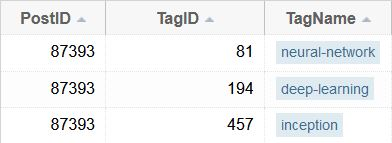

That looks good, as these 3 tags indeed appear for this same post in `Posts`. Let's also download the contents of `PostTags` then, and combine with information from `Posts` and from `Tags`. Having the information in this format may come in handy later for our analysis: any effort to group by tags would be more straightforward, saving the possible effort of string-parsing of the combined `Tags` field in the `Posts` table, and reorganizing dataframes for the result of that.

Query:
```
WITH SelectedPosts AS

(
SELECT Id, 
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Title,
       Tags,
       AnswerCount,
       FavoriteCount
  FROM Posts
 WHERE PostTypeId = 1
   AND CreationDate >= Convert(datetime, '2021-01-01' )
   AND CreationDate <  Convert(datetime, '2022-01-01' )
   )
   
SELECT sp.*,
       pt.TagId,
       t.TagName 
  FROM SelectedPosts sp
       LEFT JOIN PostTags pt ON sp.Id = pt.PostID
       LEFT JOIN Tags t ON pt.TagId = t.Id
```
Screenshot of the result:


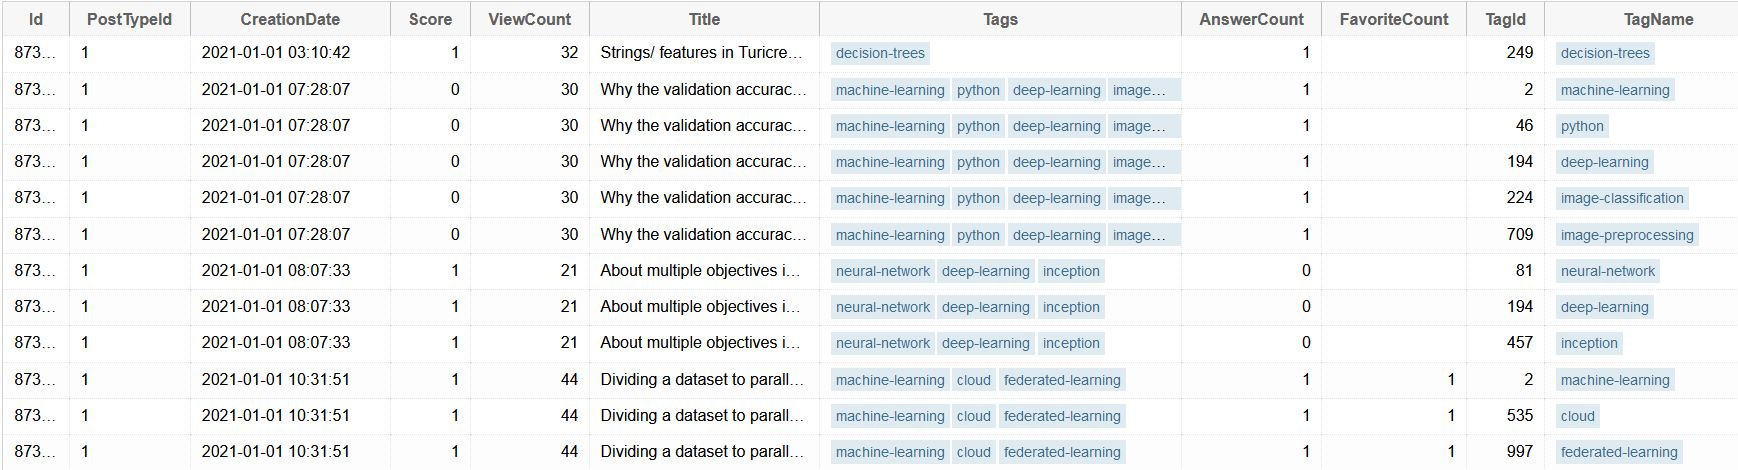

That appears correct. Let's download this one too in `.csv` format: `SelectedPostsTags.csv`.

In addition, let's also download the Tags table in full in `.csv` format: `Tags.csv`. (Query and sample screenshot not included here. It also contains a potentially interesting field `Count` though. So that may well be a count immediately how many times a tag is used, however do note that that will be for the entire time-line, and won't give a subset for 2021.)

## 3. Exploring and cleaning the data

In this section we will import the .csv-files into dataframes, and do some initial exploration. Then we will figure out whether we can use `PostsTags` (the version with one entry per post-tag combination) indeed.

After that we'll do any required cleaning.


In [4]:
# Import "SelectedPosts" and show a sample
posts = pd.read_csv("SelectedPosts.csv", parse_dates = ["CreationDate"])
posts.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Title,Tags,AnswerCount,FavoriteCount
0,87391,1,2021-01-01 03:10:42,1,32,Strings/ features in Turicreate decision tree,<decision-trees>,1,NaN
1,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN
2,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,NaN
3,87395,1,2021-01-01 10:31:51,1,44,Dividing a dataset to parallelize machine lear...,<machine-learning><cloud><federated-learning>,1,1.0
4,87404,1,2021-01-01 18:00:21,1,58,Effects of slipperiness in OpenAI FrozenLake E...,<reinforcement-learning><openai-gym>,1,NaN
5,87405,1,2021-01-01 18:18:01,2,111,How to get the maximum likelihood estimate of ...,<optimization><categorical-data><mathematics><...,0,NaN
6,87413,1,2021-01-02 01:21:52,1,141,Concatenation of CNN and LSTM to model time of...,<neural-network><deep-learning><cnn><lstm><rnn>,0,NaN
7,87414,1,2021-01-02 08:21:41,-1,42,Why are the Loss and Accuracy metrics not suit...,<accuracy><metric><loss>,1,1.0
8,87416,1,2021-01-02 10:57:58,1,30,Help Interpreting Machine Learning Results,<machine-learning><regression><cnn>,0,NaN
9,87417,1,2021-01-02 11:06:52,1,67,Which visualization tool should I use?,<visualization><graphs><tableau><powerbi>,1,NaN


In [5]:
# Check the number of rows and columns
posts.shape

(6206, 9)

In [6]:
# Confirm that indeed there is one entry per post

posts["Id"].nunique()

6206

Now let us also import the version that appeared to contain one row per post-tag combination. And check further whether that is really what it should be.

In [7]:
# Import "SelectedPostsTags" and show the first rows (so we can compare)
poststags = pd.read_csv('SelectedPostsTags.csv',parse_dates = ["CreationDate"])
poststags.head(30)

,Id,PostTypeId,CreationDate,Score,ViewCount,Title,Tags,AnswerCount,FavoriteCount,TagId,TagName
0,87391,1,2021-01-01 03:10:42,1,32,Strings/ features in Turicreate decision tree,<decision-trees>,1,NaN,249,decision-trees
1,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN,2,machine-learning
2,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN,46,python
3,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN,194,deep-learning
4,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN,224,image-classification
5,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,NaN,709,image-preprocessing
6,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,NaN,81,neural-network
7,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,NaN,194,deep-learning
8,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,NaN,457,inception
9,87395,1,2021-01-01 10:31:51,1,44,Dividing a dataset to parallelize machine lear...,<machine-learning><cloud><federated-learning>,1,1.0,2,machine-learning


In [8]:
# Check the number of rows and columns
poststags.shape

(19622, 11)

In [9]:
# Check the number of unique post numbers
poststags["Id"].nunique()

6206

In [10]:
# Check the number of entries per PostID
poststags.groupby(["Id"]).size()

Id
87391     1
87392     5
87393     3
87395     3
87404     2
         ..
106589    5
106592    2
106593    2
106596    3
106598    3
Length: 6206, dtype: int64

What the output in the cells above shows:
* the number of PostIDs for `Posts` and `PostsTags` is the same
* when manually checking some entries, indeed we see that an entry in `Posts` with e.g. 5 tags shows as 5 entries in `PostsTags`, with the corresponding 5 tags.
* when doing a count on the number of lines per post in `PostsTags` and compare this with `Tags` for some more posts, that also is correct.

So it looks safe to use `PostsTags` (the version with one entry per post-tag combination) for our further analysis.

### Data cleaning
The sample shown above already indicated that `FavoriteCount` seems to have null-values. Let's see whether there is more.

In [11]:
poststags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19622 entries, 0 to 19621
Data columns (total 11 columns):
Id               19622 non-null int64
PostTypeId       19622 non-null int64
CreationDate     19622 non-null datetime64[ns]
Score            19622 non-null int64
ViewCount        19622 non-null int64
Title            19622 non-null object
Tags             19622 non-null object
AnswerCount      19622 non-null int64
FavoriteCount    1854 non-null float64
TagId            19622 non-null int64
TagName          19622 non-null object
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 1.6+ MB


So apart from `FavoriteCount`, all seems correct. For FavoriteCount, assuming that a null-value means that it was not marked as a favorite is reasonable, so let's replace them with a 0. And let's make this an integer.

In [12]:
# Check the numbers before replacing NaN with 0
poststags["FavoriteCount"].value_counts()

1.0    1492
0.0     183
2.0     145
3.0      29
5.0       5
Name: FavoriteCount, dtype: int64

In [13]:
# Replace NaN with 0, make it an integer, show a sample to check
poststags["FavoriteCount"].fillna(0, inplace = True)
poststags["FavoriteCount"] = poststags["FavoriteCount"].astype(int)
poststags.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Title,Tags,AnswerCount,FavoriteCount,TagId,TagName
0,87391,1,2021-01-01 03:10:42,1,32,Strings/ features in Turicreate decision tree,<decision-trees>,1,0,249,decision-trees
1,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,0,2,machine-learning
2,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,0,46,python
3,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,0,194,deep-learning
4,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,0,224,image-classification
5,87392,1,2021-01-01 07:28:07,0,30,Why the validation accuracy is constant for al...,<machine-learning><python><deep-learning><imag...,1,0,709,image-preprocessing
6,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,0,81,neural-network
7,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,0,194,deep-learning
8,87393,1,2021-01-01 08:07:33,1,21,About multiple objectives in Inception networks,<neural-network><deep-learning><inception>,0,0,457,inception
9,87395,1,2021-01-01 10:31:51,1,44,Dividing a dataset to parallelize machine lear...,<machine-learning><cloud><federated-learning>,1,1,2,machine-learning


In [14]:
# Check the numbers afterwards to confirm
poststags["FavoriteCount"].value_counts()

0    17951
1     1492
2      145
3       29
5        5
Name: FavoriteCount, dtype: int64

Looks like we have clean data in our dataframe `poststags` now. We are ready to start analyzing!

## 3. Popular tags

As described in the introduction, we can count tags to learn about popular tags, and can do so in multiple ways. In the cells that follow, we will derive the following:
* **Tag usage.** Count how many times each tag was added to a post.
* **Tag views.** Count how many times each tag was viewed: if a post was views 12 times, then each of the tags of this post were viewed 12 times.
* **Tag score.** Calculate a tag-score for every tag: a score (which is upvotes minus downvotes) of 7 for a post adds 7 to the score of all of its tags.
* **Tag favorite-score**. Calculate a tag-favorite-score for every tag: if a post was marked favorite by 3 persons, all tags of the post gets 3 points for this score.

In [15]:
# Count how many times each tag ws used
tags_count = poststags["TagName"].value_counts()
tags_count.head(10)

machine-learning    1659
python              1149
deep-learning        902
neural-network       565
nlp                  529
classification       504
keras                490
tensorflow           480
time-series          371
scikit-learn         360
Name: TagName, dtype: int64

In [16]:
# Count how many times each tag was viewed (by summing up ViewCount)
tags_viewcount = poststags.groupby("TagName")["ViewCount"].sum().sort_values(ascending = False)
tags_viewcount.head(10)

TagName
python              209042
machine-learning    146015
deep-learning       100146
keras                83588
tensorflow           83553
pandas               70254
scikit-learn         66944
nlp                  54834
neural-network       47926
numpy                44862
Name: ViewCount, dtype: int64

In [17]:
# Verify correctness by checking totals
print(poststags["ViewCount"].sum(), 'should be same as', tags_viewcount.sum())

2329537 should be same as 2329537


In [18]:
# Count for every tag the total score (by summing up Score)
tags_scorecount = poststags.groupby("TagName")["Score"].sum().sort_values(ascending = False)
tags_scorecount.head(10)

TagName
machine-learning    1203
python               644
deep-learning        588
classification       382
nlp                  380
neural-network       340
keras                247
tensorflow           227
scikit-learn         221
time-series          208
Name: Score, dtype: int64

In [19]:
# Verify correctness by checking totals
print(poststags["Score"].sum(), 'should be same as', tags_scorecount.sum())

12456 should be same as 12456


In [20]:
# Count for every tag the total favorite-score (by summing up FavoriteCount)
tags_favoritecount = poststags.groupby("TagName")["FavoriteCount"].sum().sort_values(ascending = False)
tags_favoritecount.head(10)

TagName
machine-learning    214
deep-learning       110
python               97
neural-network       55
nlp                  54
classification       51
keras                39
tensorflow           36
scikit-learn         34
regression           32
Name: FavoriteCount, dtype: int32

In [21]:
# Verify correctness by checking totals
print(poststags["FavoriteCount"].sum(), 'should be same as', tags_favoritecount.sum())

1894 should be same as 1894


Let's plot the results for all four, where will pick the top 20's.

In [22]:
# Initial simple bar-chart; commented out after creation of the picture with the subplots
# tags_count.head(20).sort_values().plot(kind = 'barh', title = 'Number of times the tag was used')
# plt.show()

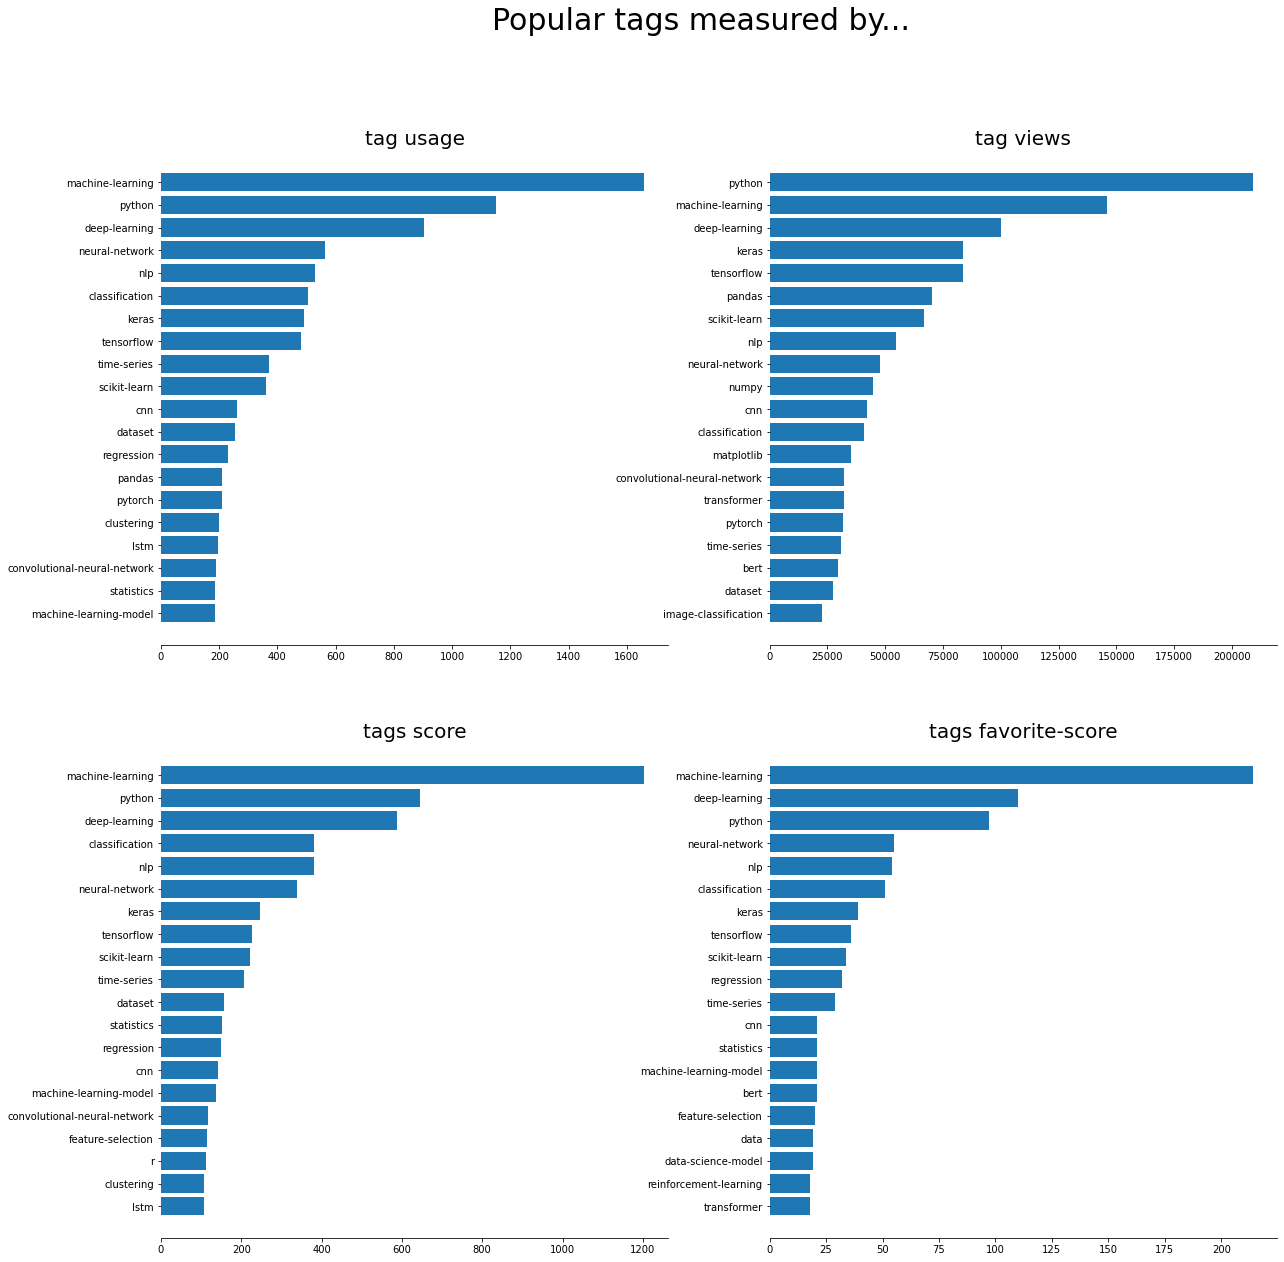

In [23]:
# Create a plot with 4 subplots (2 rows and 2 columns)
fig, ax = plt.subplots(2, 2, figsize = (20,20))

# Set overall title
fig.suptitle("Popular tags measured by...", fontsize=30)

# Fill the 4 sub-plots with the 4 results, with titles and limited spines
# (This piece of code could be shorter.)
ax[0, 0].barh(tags_count.head(20).sort_values().index, tags_count.head(20).sort_values().values) #row=0, col=0
ax[0, 1].barh(tags_viewcount.head(20).sort_values().index, tags_viewcount.head(20).sort_values().values) #row=0, col=1
ax[1, 0].barh(tags_scorecount.head(20).sort_values().index, tags_scorecount.head(20).sort_values().values) #row=1, col=0
ax[1, 1].barh(tags_favoritecount.head(20).sort_values().index, tags_favoritecount.head(20).sort_values().values) #row=1, col=1
ax[0, 0].set_title('tag usage', fontsize=20)
ax[0, 1].set_title('tag views', fontsize=20)
ax[1, 0].set_title('tags score', fontsize=20)
ax[1, 1].set_title('tags favorite-score', fontsize=20)
ax[0, 0].spines[["right", "left", "top"]].set_visible(False)
ax[0, 1].spines[["right", "left", "top"]].set_visible(False)
ax[1, 0].spines[["right", "left", "top"]].set_visible(False)
ax[1, 1].spines[["right", "left", "top"]].set_visible(False)

plt.show()

While there are some differences, there are especially a lot of similarities between the four statistics. For all of them, the top 3 consists of (although not for all in the same sequence):
* machine-learning
* python
* deep-learning

This gives some indication about popular topics already. However, we need to a more critical and take a deeper look, before just concluding that these would be the topics to select (and create content for). Read on in the next section.


## 4. Popular tags, further analysis

A first concern about just taking the most popular tags as outlined above is that some of these tags are very broad. Take e.g. "python": this would not be specific enough as a topic-of-interest to create learning-content about.

Then, also tags will be related and appear together on many occassions. Again taking "python" as an example, it is not unlikely that people will have added this tag in combination with others. E.g. it seems not unlikely that if a post is tagged with 'pandas', it is also tagged with 'python', as Pandas is a Python library. Tags 'machine-learning' and 'deep-learning' may come together as well. Tags 'python' and 'r' are possibly less used in combination (unless someone wants to compare the two?). Having insight in such related tags (topics) will help us come to better conclusions.

To get more insight into this, we can refer to the [Data science tag descriptions](https://datascience.stackexchange.com/tags) on StackExchange. Reading these descriptions we can figure out which tags may well be related, and that (domain) knowledge can help us to better interpret the statistics.

We will get back to that. However, let's actually do some data analysis first to figure out more about tags that go together a lot.

### Pairs of tags

For pairs of tags, an indication of relationship is to calculate the fraction of times that a tag B *also* appears on posts that come with a tag A. For example, we have some 200 posts with tag 'pandas'. If on 160 of them, also the tag 'python' appears, this fraction "B in case of A" would be 160/200 = 0.8. Do note that this metric is not symmetric. Or actually, given the different usages numbers, from the approximately 1200 posts with tag 'python', only 200 could possibly contain the tag 'pandas', capping the fraction "A in case of B" at 0.17 maximum already.

For groups of tags (more than two), one could take the pairs with high percentages, and for those check if there is another tag for which the percentage is high, in similar way. Let's not go that way though. More in general, there are more advanced techniques for such analyses for related tags, which we will also not apply now.

Let us calculate the fractions "tag B in case of tag A" that we described. For this, we will use the 15 most popular tags as per "tag usage". For those we will build a 15x15-matrix, with the fractions as cells. Then we can show this in the form of a heatmap.

In [24]:
# Create a function that for a pair of tags calculates the percentage
# This approach of cell-by-cell calculation may imply a performance risk. Let's try it out though.

def calc_fraction (tag1, tag2):
    # Select PostIDs of tag 1
    tag1_postIDs = poststags[poststags["TagName"] == tag1]["Id"]
    # Calculate the number of posts
    tag1_count = len(tag1_postIDs)
    # Select those posts for which (1) the ID is in this list AND (2) the tag is tag 2
    # Calculate how many of those there are
    tag2_count = poststags[(poststags["Id"].isin(tag1_postIDs)) & (poststags["TagName"] == tag2)].shape[0] 
    #print(tag1_postIDs) Commented out, was used for verifying and debugging
    #print(tag1_count)   Commented out, was used for verifying and debugging
    #print(tag2_count)   Commented out, was used for verifying and debugging
    # Return the fraction
    return tag2_count / tag1_count

To verify the correctness of the function above, several experiments were done using the 'print' statements, and comparing that with the data in `poststags`. Not all of those are included here; do find below the following checks though:
* calculate the fraction where tag1 and tag2 are the same; this should be 1.0
* for a tag of which there are only a few occurences, manually check the result; selected was tag `spss` with 4 occurences

In [25]:
# Calculate the fraction where tag1 and tag2 are the same:
calc_fraction("statistics", "statistics")

1.0

In [26]:
# Show all rows for tag 'spss'
poststags[poststags["TagName"]=='spss']

,Id,PostTypeId,CreationDate,Score,ViewCount,Title,Tags,AnswerCount,FavoriteCount,TagId,TagName
2954,90320,1,2021-03-05 19:58:18,0,42,"Doing a cox regression, how do I analyze a con...",<regression><spss>,1,0,411,spss
4659,92878,1,2021-04-10 22:01:53,0,11,Check the Reliability of Questionnaire using spss,<spss>,0,0,411,spss
7993,94972,1,2021-05-27 13:23:55,0,112,Why do I get different coefficients from Logis...,<python><scikit-learn><logistic-regression><spss>,1,0,411,spss
12764,100258,1,2021-08-19 01:19:43,0,6,How to model multinomail logistic regression t...,<regression><statistics><data><spss>,0,0,411,spss


What we can see is that for these 4 posts:
* in 2 of them the tag `regression` is used; so the fraction should be 0.5
* in 1 of them the tag `python` is used; so the fraction should be 0.25
Let's check!

In [27]:
calc_fraction("spss","regression")

0.5

In [28]:
calc_fraction("spss","python")

0.25

That looks good.

Now we have a function that can calculate these fractions, we can build another function that we can offer a selection of tags, and then returns a dataframe with all the percentages.

In [29]:
# Create a function that for a selection of tags returns a fraction matrix
def build_fraction_matrix (taglist):
    fraction_matrix = pd.DataFrame(0.0, columns=selected_tags, index = selected_tags)
    for tag1 in taglist:
        for tag2 in taglist:
            the_fraction = calc_fraction(tag1, tag2)
            # print('Tag1: ', tag1, 'Tag2: ', tag2, 'Fraction:', the_fraction) Commented out, was used for verifying and debugging
            fraction_matrix.at[tag1, tag2] = the_fraction
    return fraction_matrix        
           
    

Let's test this again on a small sample:

In [30]:
selected_tags = ('spss','regression', 'python')
related_tags_matrix_sample = build_fraction_matrix(selected_tags)
related_tags_matrix_sample

,spss,regression,python
spss,1.000000,0.50000,0.250000
regression,0.008696,1.00000,0.134783
python,0.000870,0.02698,1.000000


Since that complies with the values that we saw earlier, confident that the works.

Let's now run this for the top-15 tags that have been used.

In [31]:
# Create a matrix "Also tag B in case of tag A" for the most popular tags
selected_tags = tags_count.head(15).index
related_tags_matrix = build_fraction_matrix(selected_tags)
related_tags_matrix

,machine-learning,python,deep-learning,neural-network,nlp,classification,keras,tensorflow,time-series,scikit-learn,cnn,dataset,regression,pandas,pytorch
machine-learning,1.000000,0.165160,0.195298,0.106088,0.074744,0.121760,0.049427,0.052441,0.043400,0.064497,0.023508,0.033755,0.048222,0.011453,0.013864
python,0.238468,1.000000,0.100957,0.055701,0.086162,0.059182,0.113142,0.102698,0.071366,0.128808,0.027850,0.029591,0.026980,0.116623,0.045257
deep-learning,0.359202,0.128603,1.000000,0.195122,0.082040,0.063193,0.151885,0.148559,0.047672,0.012195,0.120843,0.035477,0.018847,0.002217,0.063193
neural-network,0.311504,0.113274,0.311504,1.000000,0.046018,0.063717,0.141593,0.102655,0.046018,0.019469,0.077876,0.019469,0.038938,0.001770,0.056637
nlp,0.234405,0.187146,0.139887,0.049149,1.000000,0.060491,0.032136,0.037807,0.000000,0.030246,0.001890,0.017013,0.005671,0.005671,0.028355
classification,0.400794,0.134921,0.113095,0.071429,0.063492,1.000000,0.039683,0.019841,0.059524,0.071429,0.043651,0.027778,0.039683,0.003968,0.013889
keras,0.167347,0.265306,0.279592,0.163265,0.034694,0.040816,1.000000,0.477551,0.071429,0.026531,0.089796,0.026531,0.026531,0.006122,0.020408
tensorflow,0.181250,0.245833,0.279167,0.120833,0.041667,0.020833,0.487500,1.000000,0.035417,0.012500,0.087500,0.041667,0.025000,0.004167,0.039583
time-series,0.194070,0.221024,0.115903,0.070081,0.000000,0.080863,0.094340,0.045822,1.000000,0.016173,0.026954,0.040431,0.056604,0.024259,0.018868
scikit-learn,0.297222,0.411111,0.030556,0.030556,0.044444,0.100000,0.036111,0.016667,0.016667,1.000000,0.002778,0.022222,0.038889,0.052778,0.000000


Let's present this in the form of a heatmap.

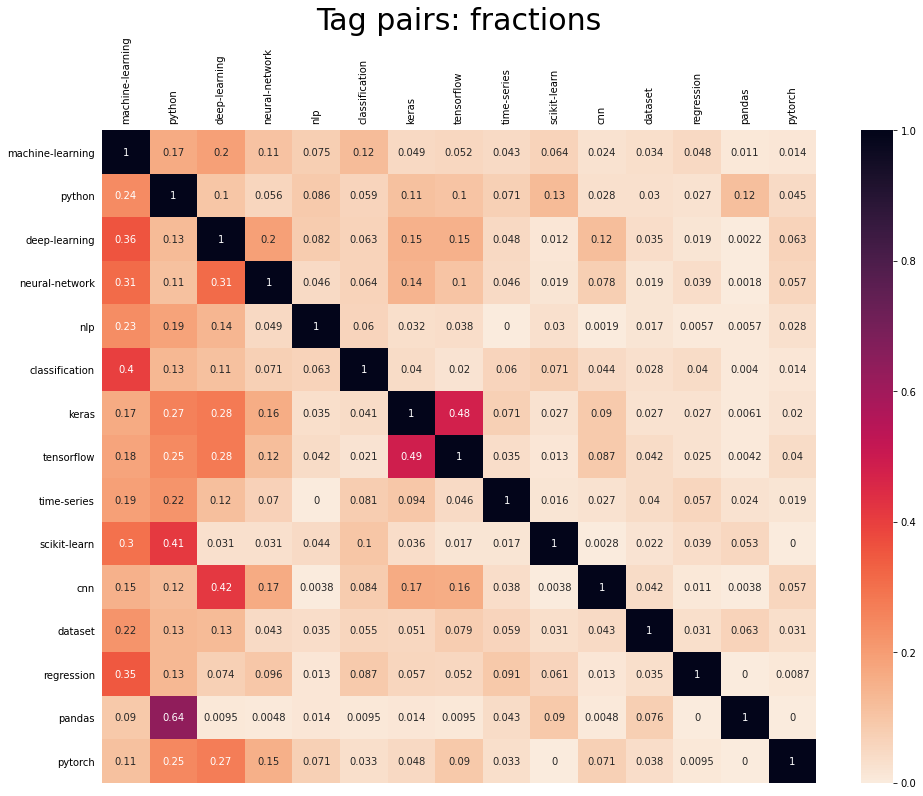

In [32]:
# Plot a heatmap; include values in the cell; use a color scheme in which high values are darker colors
fig, ax = plt.subplots(figsize=(16,12))  
ax = sns.heatmap(related_tags_matrix, annot = True, cmap = sns.cm.rocket_r)

ax.set_title("Tag pairs: fractions", fontsize=30)

# Move the x-axis labels to the top; rotate them; do not show ticks
ax.xaxis.set_ticks_position('top')
for item in ax.get_xticklabels():
   item.set_rotation(90)
ax.tick_params(left=False, top=False)

plt.show()

So, how do we read this? Select a tag in a row (*row-tag*). Then select a tag in a column (*column-tag*). The number in the cell represents "of all posts having the *row-tag*, the fraction also having the *column-tag*.

We can indeed see what we suspected earlier: of the posts tagged with "pandas", 64% is also tagged with "python".
Another observations is that tags "keras" and "tensorflow" are used together a lot. Tags "machine-learning" and "python" are generally added quite a lot it seems.

Overall, what there is to learn from this analysis of pairs is not that much though: overall the numbers are relatively low; no things that really stand out and give us that much information about the question we're trying to answer.

### Finding a topic

Let's revisit our list of popular tags and assess what we know by now, combining our statistics with domain knowledge, embodied by [tag descriptions](https://datascience.stackexchange.com/tags). And see if we can get somewhere with that now.

Tag `machine-learning` is on top of the list. It is still a fairly broad topic though, and this tag seems to be added quite a lot with other more specific tags.
Tag `python` is next. This is even broader.
Tag `deep-learning` is next on the list. That's an interesting one. Popular, but already more specific.

So possibly "deep learning" is a good candidate? It may be. There is one thing that we would want to check though: is it a [fad](https://dictionary.cambridge.org/dictionary/english/fad)?

## 5. Deep learning, popularity over time

So in 2021 "deep-learning" was popular, in a sense that the tag was used a lot. We would want to check though whether this  popularity is short-lived, in which case we still wouldn't want to recommend it as a topic to create content about.

To do this analysis, we'll do two things:
* use data of all other years for which there is data in the Data science site of Stack Exchange, and figure out the percentage of posts about "deep-learning" over time
* be more precise in defining which posts are about "deep-learning"

Regarding that latter, getting back to what we discussed in the previous section: tags are related, and there are other tags that directly related to deep learning as well. In particular `neural-network`, `keras` and `tensorflow`. (Check it with the [tag descriptions](https://datascience.stackexchange.com/tags), or on the internet in other ways.)

### Extracting additional data

Let's re-run the query on our data source, but now for the full time-line instead of 2021 only (and removing columns that we don't need).

```
WITH SelectedPosts AS

(
SELECT Id, 
       PostTypeId,
       CreationDate,
       Tags
  FROM Posts
 WHERE PostTypeId = 1
 AND CreationDate >= Convert(datetime, '2019-01-01' )
)

SELECT sp.*,
       t.TagName 
  FROM SelectedPosts sp
       LEFT JOIN PostTags pt ON sp.Id = pt.PostID
       LEFT JOIN Tags t ON pt.TagId = t.Id
```


That turns out to return exactly 50,000 rows. To work around this limitation we'll do this in 3 batches (which we will combine again later after importing). E.g. like this:

```
WITH SelectedPosts AS

(
SELECT Id, 
       PostTypeId,
       CreationDate,
       Tags
  FROM Posts
 WHERE PostTypeId = 1
 AND CreationDate >= Convert(datetime, '2019-01-01' )
 AND CreationDate < Convert(datetime, '2021-01-01' )
)

SELECT sp.*,
       t.TagName 
  FROM SelectedPosts sp
       LEFT JOIN PostTags pt ON sp.Id = pt.PostID
       LEFT JOIN Tags t ON pt.TagId = t.Id
```

The results were saved in:
- `PostsTags_part1.csv` (< 2019-01)
- `PostsTags_part2.csv` (>=2019-01 AND < 2021-01-01)
- `PostsTags_part3.csv` (>=2021-01 AND < 2022-04-01) (the latter restriction to not include the current incomplete month)

And stored in the same folder in this notebook.

### Importing the data
Let's import them, then do a couple of sanity checks (some included in this notebook), and combine them into one dataframe.

In [33]:
# Read in the 3 parts
poststags_part1 = pd.read_csv("PostsTags_part1.csv", parse_dates = ["CreationDate"])
poststags_part2 = pd.read_csv("PostsTags_part2.csv", parse_dates = ["CreationDate"])
poststags_part3 = pd.read_csv("PostsTags_part3.csv", parse_dates = ["CreationDate"])

In [34]:
# Check numbers of rows and columns
print (poststags_part1.shape)
print (poststags_part2.shape)
print (poststags_part3.shape)

(35051, 5)
(40500, 5)
(24238, 5)


In [35]:
# Check continuitity by showing the last 5 entries of part 2....
poststags_part2.tail(5)

,Id,PostTypeId,CreationDate,Tags,TagName
40495,87389,1,2020-12-31 20:33:17,<neural-network><nlp><bert><transformer><langu...,nlp
40496,87389,1,2020-12-31 20:33:17,<neural-network><nlp><bert><transformer><langu...,language-model
40497,87389,1,2020-12-31 20:33:17,<neural-network><nlp><bert><transformer><langu...,neural-network
40498,87389,1,2020-12-31 20:33:17,<neural-network><nlp><bert><transformer><langu...,transformer
40499,87389,1,2020-12-31 20:33:17,<neural-network><nlp><bert><transformer><langu...,bert


In [36]:
# ... followed by the first 5 entries of part 3
poststags_part3.head(5)

,Id,PostTypeId,CreationDate,Tags,TagName
0,87391,1,2021-01-01 03:10:42,<decision-trees>,decision-trees
1,87392,1,2021-01-01 07:28:07,<machine-learning><python><deep-learning><imag...,machine-learning
2,87392,1,2021-01-01 07:28:07,<machine-learning><python><deep-learning><imag...,python
3,87392,1,2021-01-01 07:28:07,<machine-learning><python><deep-learning><imag...,deep-learning
4,87392,1,2021-01-01 07:28:07,<machine-learning><python><deep-learning><imag...,image-classification


In [37]:
# Combine the 3 parts in one dataframe 
poststags_all = poststags_part1.append(poststags_part2).append(poststags_part3)

In [38]:
# Check the number of rows
print("Number of rows", poststags_all.shape[0], "should be", poststags_part1.shape[0] + poststags_part2.shape[0] + poststags_part3.shape[0])

Number of rows 99789 should be 99789


So we have one dataframe now for the entire timeline, with all relevant data. 

### Analyzing the data

We'll first add a column for the month in which the post was created. 

In [39]:
# Add a column that indicates the month
poststags_all["CreationMonth"] = poststags_all["CreationDate"].dt.strftime("%Y-%m")

In [40]:
# To verify, check a sample
poststags_all.sample(10)

,Id,PostTypeId,CreationDate,Tags,TagName,CreationMonth
7244,94600,1,2021-05-18 12:48:22,<python><regression><xgboost><overfitting><hyp...,hyperparameter-tuning,2021-05
40340,87258,1,2020-12-28 19:23:12,<neural-network><time-series>,time-series,2020-12
35459,81349,1,2020-09-07 20:46:34,<machine-learning><predictive-modeling><machin...,predictive-modeling,2020-09
22795,30167,1,2018-04-11 11:43:24,<machine-learning><classification><time-series...,machine-learning,2018-04
10795,98009,1,2021-07-17 17:13:44,<python><time-series><r><forecasting><feature-...,feature-importances,2021-07
5511,10763,1,2016-03-17 17:48:05,<python><logistic-regression><linear-regressio...,cross-validation,2016-03
16285,61564,1,2019-10-10 14:42:19,<machine-learning><neural-network><classificat...,nlp,2019-10
7774,13169,1,2016-08-03 14:49:21,<python><nlp><pandas><topic-model><lda>,topic-model,2016-08
7951,52112,1,2019-05-17 09:29:55,<bigdata><apache-spark><dataframe><scala>,scala,2019-05
11657,99613,1,2021-08-02 15:02:17,<python><opencv>,python,2021-08


Having a column with the month of creation of the post, we can now start grouping on that column and count for every month:
* number of posts overall
* number of posts related to deep-learning, that is, having one of our "selected" tags

In [41]:
# Count the number of posts per month (= unique post-ID's)
posts_per_month = poststags_all.groupby("CreationMonth")["Id"].nunique()
# Show result
posts_per_month

CreationMonth
2014-05     58
2014-06     99
2014-07     76
2014-08     64
2014-09     48
          ... 
2021-11    537
2021-12    458
2022-01    505
2022-02    472
2022-03    503
Name: Id, Length: 95, dtype: int64

In [42]:
# To verify if the number is still the same as in the original dataframe
print(posts_per_month.sum(), 'should be', poststags_all["Id"].nunique())

32633 should be 32633


In [43]:
# Specify our 'qualifying-tags' that indicate whether a post is about deep learning
qualifying_tags = ["deep-learning", "neural-network", "keras", "tensorflow"]
            
# Count the number of posts per month with one of these tags (unique post-ID's)
posts_per_month_qualifying = poststags_all[poststags_all["TagName"].isin(qualifying_tags)].groupby("CreationMonth")["Id"].nunique()

# Show result
posts_per_month_qualifying

CreationMonth
2014-05      1
2014-06      6
2014-07      6
2014-08      1
2014-09      1
          ... 
2021-11    134
2021-12    117
2022-01    135
2022-02    131
2022-03    115
Name: Id, Length: 95, dtype: int64

In [44]:
# Check the totals, values should be reasonable in comparison to the total number of posts
posts_per_month_qualifying.sum()

9139

Looks like we have the correct data. (Some additional checks were done that are not included in this notebook anymore.)
Let's create a dataframe that combines these two series, and also calculates the fraction.

In [45]:
# Combine two series in a dataframe
data_over_time = pd.concat([posts_per_month, posts_per_month_qualifying], axis=1, keys = ['posts_per_month', 'posts_per_month_qualifying'], sort = True)
# Calculate the fraction (by dividing the two columns)
data_over_time["fraction_qualifying"] = data_over_time["posts_per_month_qualifying"]/data_over_time["posts_per_month"]
# Show the result
data_over_time

,posts_per_month,posts_per_month_qualifying,fraction_qualifying
CreationMonth,,,
2014-05,58,1,0.017241
2014-06,99,6,0.060606
2014-07,76,6,0.078947
2014-08,64,1,0.015625
2014-09,48,1,0.020833
...,...,...,...
2021-11,537,134,0.249534
2021-12,458,117,0.255459
2022-01,505,135,0.267327


Let's visualize this data.

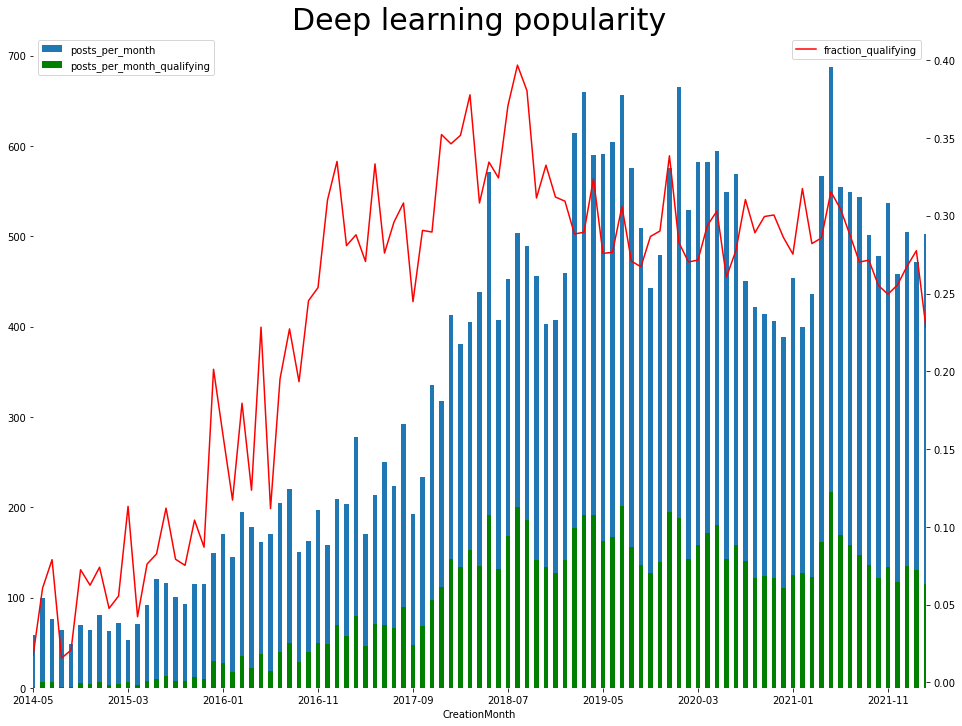

In [46]:
# Create plot
fig, axes = plt.subplots(figsize=(16,12))  

axes.set_title("Deep learning popularity", fontsize=30)

# Show bars for question-countss, and a line for the fraction
ax1 = data_over_time['posts_per_month'].plot.bar()
ax2 = data_over_time['posts_per_month_qualifying'].plot.bar(color = 'green')
ax3 = data_over_time['fraction_qualifying'].plot(secondary_y=True, color = 'red')

# Only show a limited set of ticks on the X-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))

# Add legend
ax1.legend()
ax2.legend()
ax3.legend()

# Remove the box around the graph (there should be a simpler way for this...)
ax1.spines[['top','bottom', 'left', 'right']].set_visible(False)
ax2.spines[['top','bottom', 'left', 'right']].set_visible(False)
ax3.spines[['top','bottom', 'left', 'right']].set_visible(False)

plt.show()

To avoid spikes in the line it might have been clearer to aggregate the data per quarter or per year rather than per month. However, however also from this graph it seems fair to observe that:
* the percentage of questions related to deep learning grew from less than 5% in 2014 to almost 40% (!) in 2018
* since the percentage dropped down somewhat but not that much, while the absolute number of questions was reasonably stable

## 6. Conclusion

There is definitely more scope for analysis still. However, based on the above it seems fair to say that "deep-learning" is a topic that people ask a significant amount of questions about since years. It may be a good topic to select for content creation for learning materials.